In [ ]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
import string
from os import listdir
from keras.utils import plot_model
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception 
from keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.layers import concatenate,add
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.layers import LSTM, Embedding, Dropout
from tqdm.notebook import tqdm
import pandas as pd
import nltk

In [195]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [196]:
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [197]:
df = pd.read_csv('/content/gdrive/MyDrive/pmpts.csv')

In [198]:
df.head()

,imgId,prompt
0,20057f34d,hyper realistic photo of very friendly and dys...
1,227ef0887,"ramen carved out of fractal rose ebony, in the..."
2,92e911621,ultrasaurus holding a black bean taco in the w...
3,a4e1c55a9,a thundering retro robot crane inks on parchme...
4,c98f79f71,"portrait painting of a shimmering greek hero, ..."


In [199]:
def process_review(review):
    processed_token = []
    for token in review.split():
        token = ''.join(e.lower() for e in token if e.isalnum())
        processed_token.append(token)
    return ' '.join(processed_token)

In [200]:
df['processed_prompt'] = df['prompt'].apply(lambda x: process_review(x))

In [201]:
df.head()

,imgId,prompt,processed_prompt
0,20057f34d,hyper realistic photo of very friendly and dys...,hyper realistic photo of very friendly and dys...
1,227ef0887,"ramen carved out of fractal rose ebony, in the...",ramen carved out of fractal rose ebony in the ...
2,92e911621,ultrasaurus holding a black bean taco in the w...,ultrasaurus holding a black bean taco in the w...
3,a4e1c55a9,a thundering retro robot crane inks on parchme...,a thundering retro robot crane inks on parchme...
4,c98f79f71,"portrait painting of a shimmering greek hero, ...",portrait painting of a shimmering greek hero n...


In [202]:
#Tokenize Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_prompt'])
vocab_size = len(tokenizer.word_index) + 1

In [203]:
max_length = max(len(caption.split()) for caption in df['processed_prompt'])
print(max_length)

23


In [232]:
dict = {}
img_id = []
prp = []
new_prp = []
for i in df['imgId']:
  img_id.append(i)
for j in df['prompt']:
  prp.append(j)

if len(img_id)>0:
  for i in range(len(img_id)):
    dict[img_id[i]] = [process_review(prp[i].translate(str.maketrans('', '', string.punctuation))).replace('\s+', ' ')]
    new_prp.append(process_review(prp[i].translate(str.maketrans('', '', string.punctuation))).replace('\s+', ' '))

In [233]:
new_prp

['hyper realistic photo of very friendly and dystopian crater',
 'ramen carved out of fractal rose ebony in the style of hudson river school',
 'ultrasaurus holding a black bean taco in the woods near an identical cheneosaurus',
 'a thundering retro robot crane inks on parchment with a droopy french bulldog',
 'portrait painting of a shimmering greek hero next to a loud frillnecked lizard',
 'an astronaut standing on a engaging white rose in the midst of by ivory cherry blossoms',
 'kaggle employee phil at a donut shop ordering all the best donuts with a speech bubble that proclaims donuts its whats for dinner']

In [234]:
captions = []
for caption in new_prp:
  caption = '<start>' + " ".join([word for word in caption.split() if len(word)>1]) + ' <end>'
  captions.append(caption)

In [235]:
captions

['<start>hyper realistic photo of very friendly and dystopian crater <end>',
 '<start>ramen carved out of fractal rose ebony in the style of hudson river school <end>',
 '<start>ultrasaurus holding black bean taco in the woods near an identical cheneosaurus <end>',
 '<start>thundering retro robot crane inks on parchment with droopy french bulldog <end>',
 '<start>portrait painting of shimmering greek hero next to loud frillnecked lizard <end>',
 '<start>an astronaut standing on engaging white rose in the midst of by ivory cherry blossoms <end>',
 '<start>kaggle employee phil at donut shop ordering all the best donuts with speech bubble that proclaims donuts its whats for dinner <end>']

In [242]:
split = int(len(img_id)*0.9)
split
train = img_id[:split]
test = img_id[split:]

In [241]:
train

['20057f34d', '227ef0887', '92e911621', 'a4e1c55a9', 'c98f79f71', 'd8edf2e40']

In [238]:
#seq = tokenizer.texts_to_sequences(df['processed_prompt'])[0]

In [ ]:
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
  X1,X2,y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n+=1
      captions = dict[key]
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1,len(seq)):
          in_seq,out_seq = seq[:i],seq[i]
          in_seq = pad_sequences([in_seq],maxlen = max_length)[0]
          out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
     
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)

          if n==batch_size:
            X1,X2,y = np.array(X1),np.array(X2),np.array(y)
            yield [X1,X2],y
            X1,X2,y = list(), list(), list()
            n = 0

In [249]:
images_path = '/content/gdrive/MyDrive/stable-diffusion-image-to-prompts/images'

In [250]:
from keras.applications.vgg19 import VGG19
model = VGG19(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
features = {}
for name in os.listdir(images_path):
    filename = os.path.join(images_path, name)
    image = Image.open(filename)
    image = image.resize((224,224))  # Resize the image to 512x512
    image = np.array(image)
    image = preprocess_input(image)
    feature = model.predict(np.expand_dims(image, axis=0))
    img_id = name.split('.')[0]
    features[img_id] = feature

1/1 [==============================] - 1s 1s/step


In [ ]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation='relu')(fe1)
#sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2) #Using softmax for categorical classification

model = Model(inputs=[inputs1,inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam',run_eagerly=True)
#plot model
#plot_model(model,show_shapes = True)

In [ ]:

epochs = 150
batch_size = 3 #setting batch_size less than 5 since we have only 5 samples to train over
steps = len(train)//batch_size
for i in range(epochs):
  generator = data_generator(train,dict,features,tokenizer,max_length,vocab_size,batch_size)
  model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

3/3 [==============================] - 1s 354ms/step - loss: 0.0991


In [ ]:
model.save('/content/gdrive/MyDrive/modellstm') 

In [267]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == '<end>':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    # actual caption
    captions = dict[key]
    # Our predicted caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1 [00:00<?, ?it/s]

BLEU-1: 0.083333
BLEU-2: 0.000000


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [291]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    image_name = image_name
    image_id = image_name.split('.')[0]
    img_path = os.path.join("/content/gdrive/MyDrive/stable-diffusion-image-to-prompts","images", image_name)
    image = Image.open(img_path)
    caption = dict[image_id]
    print('---------------------Actual---------------------')
    print(caption[0])

    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    pred = set(y_pred.split())
    str1 = ''
    for word in pred:
      str1 = str1 + ' ' + word
    new_str = ''
    for word in caption[0].split():
      if word in str1.split():
        new_str = new_str + ' ' + word
    print(new_str)
    plt.imshow(image)

---------------------Actual---------------------
hyper realistic photo of very friendly and dystopian crater
--------------------Predicted--------------------
 realistic photo of very friendly and dystopian crater


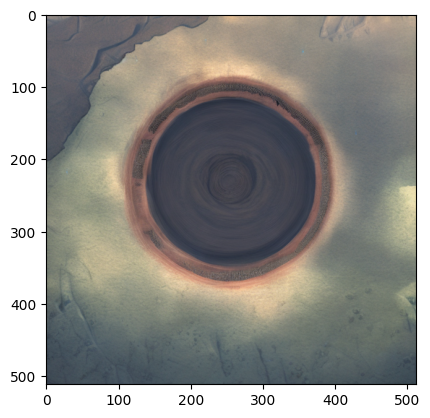

In [292]:
generate_caption("20057f34d.png")

---------------------Actual---------------------
ultrasaurus holding a black bean taco in the woods near an identical cheneosaurus
--------------------Predicted--------------------
 holding a black bean taco in the woods near an identical cheneosaurus


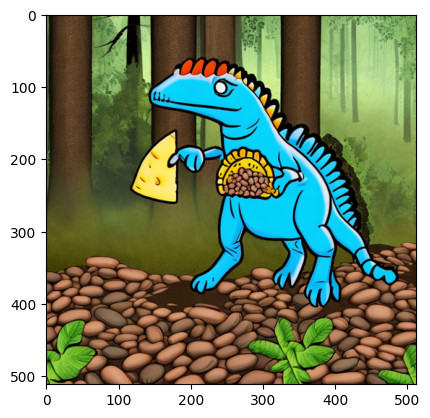

In [293]:
generate_caption("92e911621.png")